In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/training/09_15_24_ISLES_3D_Dice_wAUG",
    "/storage/vbutoi/scratch/ESE/training/09_18_24_ISLES_3D_Dice_wA_MixedPrec",
    # "/storage/vbutoi/scratch/ESE/calibration/09_18_24_ISLES_3D_LTS_wA_BS1",
    # "/storage/vbutoi/scratch/ESE/calibration/09_18_24_ISLES_3D_LTS_wA_BS1_noCompile",
    # "/storage/vbutoi/scratch/ESE/calibration/09_18_24_ISLES_3D_LTS_wA_BS1_RelativeError",
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
for key in df.keys():
    print(key)

phase
epoch
loss
dice_score
added_noise_max_sigma
added_noise_probability
bias_field_probability
gamma_scaling_max
gamma_scaling_probability
normalize_max_scale
normalize_min_quantile
use_mask
data
in_channels
out_channels
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
torch_compile
torch_mixed_precision
loss_func
batch_reduction
from_logits
model
convs_per_block
dims
filters
optim
lr
epochs
eval_freq
path


In [4]:
df['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/training/09_15_24_ISLES_3D_Dice_wAUG/20240915_140851-VXLI-95b565ac944231b08a55650cd0d4fff9'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_15_24_ISLES_3D_Dice_wAUG/20240915_140855-4SHI-140d6fbd6fbcc33a62cbbdd90a3142dd'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_15_24_ISLES_3D_Dice_wAUG/20240915_140848-JDNK-d2e118380f68db71bd23b4cedfadb19f'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_18_24_ISLES_3D_Dice_wA_MixedPrec/20240918_151303-UYLT-a020717285bb79754c54d29a493e68f8'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_18_24_ISLES_3D_Dice_wA_MixedPrec/20240918_151259-JG68-87e2e938c51d8c4fa038661ad4308bc7'),
       PosixPath('/storage/vbutoi/scratch/ESE/training/09_18_24_ISLES_3D_Dice_wA_MixedPrec/20240918_151255-CJ86-40e06ec18d0b2998b0fff1c511859701')],
      dtype=object)

In [5]:
def exp_name(path):
    return str(path).split("/")[-2]
    
df.augment(exp_name)

In [6]:
# Only keep the epochs every 10 to reduce the number of points
df = df[df['epoch'] % 10 == 0]

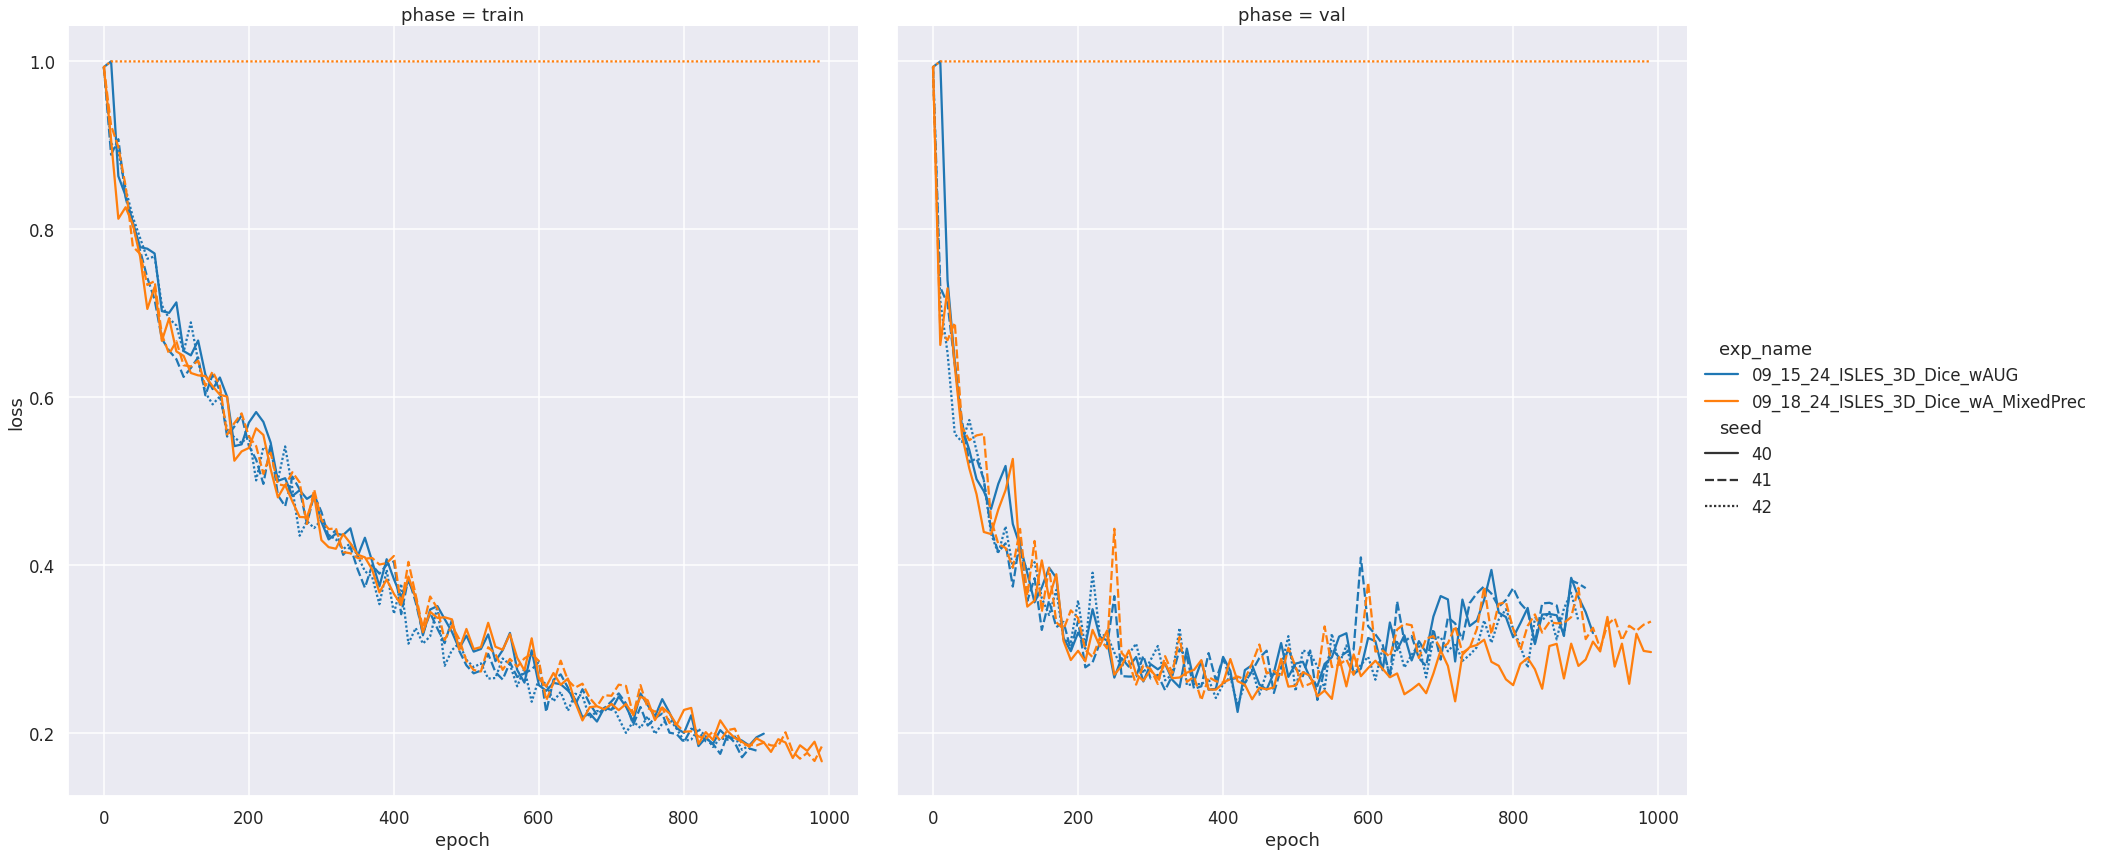

In [7]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='exp_name',
    style='seed',
    col='phase',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [8]:
# g = sns.relplot(
#     data=df,
#     x='epoch',
#     y='area_estimation_error',
#     hue='loss_func',
#     style='seed',
#     # hue='filters',
#     # style='lr',
#     col='phase',
#     kind='line',
#     height=12,
# )

# # Set column spacing
# g.fig.subplots_adjust(wspace=0.05)
# # g.set(ylim=(0.0, 0.25))